# Lesson 1 - Keras implementation of fast ai part 1 v2
- This is a Keras implementation of Jeremy Howard's fastai part 1 v2 lesson 1 (original version is in PyTorch)
- This has only been tested with the TensorFlow backend to Keras

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from fastai.utils import *
from fastai.learner import *
from fastai.dataset import *

Using TensorFlow backend.


We will use the dogs and cats dataset

path should be replaced with the path to your downloaded dogs and cats dataset

For the original Keras dogs/cats lesson1 and instructions on downloading visit:
https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson1.ipynb

In [2]:
path="/home/jeff/projects/fastai/data/dogscats/" #update with your path to cats and dogs
sz = 224

Loading in Keras' off the shelf/pretrained ResNet50 model.

***note: the PyTorch course uses ResNet34. After many hours spent writing code to convert PyTorch models and weights into Keras. I opted to use Keras' ResNet50.***

In [3]:
arch = ResNet50
data = ImageClassifierData.from_paths(path=path, tfms = tfms_from_model(arch, sz, rescale=1/255))
learn = ConvLearner.pretrained(arch, data, finetune2_layer='avg_pool')

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [7]:
learn.lr_find(jump=8)

Epoch 1/1
131/360 [=========>....................] - ETA: 39s - loss: 0.6245

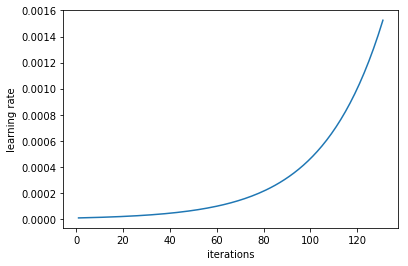

In [8]:
learn.sched.plot_lr()

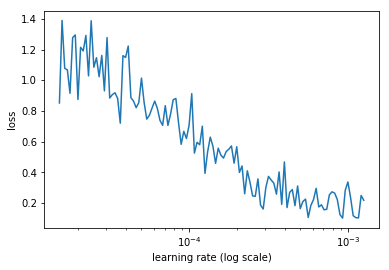

In [9]:
learn.sched.plot()

As you can see in the plot above it appears the optimal learning rate to set is .08

**Data Augmentation on the training data**

Now time to start training!  I noticed that the pretrained Keras ResNet50 model is not quite as accurate in my opinion as the pretrained PyTorch ResNet50 model.

In [10]:
tfms = tfms_from_model(arch, sz, crop_type=CropType.RANDOM, 
                  rotation_range=10, zoom_range=0.1, horizontal_flip=True, rescale=1/255)

In [11]:
#need to add random lighten
data = ImageClassifierData.from_paths(path=path, tfms = tfms)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [12]:
learn.fit(.08, 4)

Epoch 1/4
360/360 [==============================] - 64s - loss: 0.5767 - acc: 0.9543    
Epoch 2/4
360/360 [==============================] - 64s - loss: 0.4690 - acc: 0.9653    
Epoch 3/4
360/360 [==============================] - 64s - loss: 0.4211 - acc: 0.9694    
Epoch 4/4
360/360 [==============================] - 64s - loss: 0.4073 - acc: 0.9708    


Evaluate function may run a little slow.  I find that Keras generator's are not the fastest compared to the ones in the fastai PyTorch library.  Generally I try to load the entire dataset into memory, but since this repository is meant to be shared I opted for generators so that it works for a wider audience.

In [13]:
learn.model.evaluate_generator(data[1], steps=math.ceil(data[1].samples/data[1].batch_size*4), workers=4 )

[0.49611101947321395, 0.96423116089613037]

Fit for 3 epochs with a Cyclical Learning Rate

In [15]:
learn.fit(.08, 3, cycle_len=1, cycle_mult=1)

Epoch 1/3
360/360 [==============================] - 65s - loss: 0.3602 - acc: 0.9738    
Epoch 2/3
360/360 [==============================] - 65s - loss: 0.3115 - acc: 0.9766    
Epoch 3/3
360/360 [==============================] - 65s - loss: 0.3004 - acc: 0.9773    


In [16]:
learn.model.evaluate_generator(data[1], steps=math.ceil(data[1].samples/data[1].batch_size*4), workers=4 )

[0.42550717285567258, 0.96836577868852458]

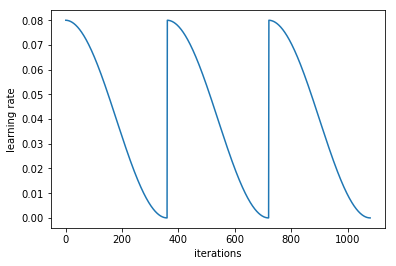

In [17]:
learn.sched.plot_lr()

In [14]:
learn.save('keras_resnet50_f2.hdf5')

Make all layers trainable

In [18]:
learn.unfreeze()

In [19]:
learn.fit([0.0001, .001, .01], 3, cycle_len=1, cycle_mult=2)

Epoch 1/7
360/360 [==============================] - 207s - loss: 0.2605 - acc: 0.9793   
Epoch 2/7
360/360 [==============================] - 204s - loss: 0.2351 - acc: 0.9822   
Epoch 3/7
360/360 [==============================] - 204s - loss: 0.1796 - acc: 0.9865   
Epoch 4/7
360/360 [==============================] - 204s - loss: 0.1861 - acc: 0.9863   
Epoch 5/7
360/360 [==============================] - 204s - loss: 0.1461 - acc: 0.9884   
Epoch 6/7
360/360 [==============================] - 204s - loss: 0.1124 - acc: 0.9913   
Epoch 7/7
360/360 [==============================] - 204s - loss: 0.1256 - acc: 0.9902   


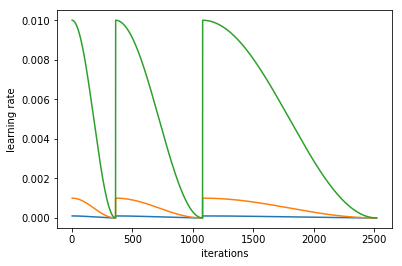

In [20]:
learn.sched.plot_lr()

In [21]:
%%time
learn.model.evaluate_generator(data[1], steps=math.ceil(data[1].samples/data[1].batch_size*4), workers=4 )

CPU times: user 1min, sys: 988 ms, total: 1min 1s
Wall time: 25.9 s


[0.25618713118484193, 0.98040471311475408]

In [ ]:
learn.save('keras_resnet50_f2_2.hdf5')